mergeAndPrep

In [1]:
import geopandas as gpd
import os
import pandas as pd
import time

In [2]:
## Prep Physiographic Regions
# https://www.sciencebase.gov/catalog/item/631405bbd34e36012efa304e
physio = gpd.read_file('/nas/cee-water/cjgleason/craig/CONUS_ephemeral_data/other_shapefiles/physio.shp')

ERROR 1: PROJ: proj_create_from_database: Open of /work/pi_cjgleason_umass_edu/.conda/envs/small-rivers-1/share/proj failed


In [3]:
# Dissolve provinces by division
physio = physio.dissolve(by='DIVISION').reset_index()

In [4]:
# Set CRS to Web Mercator
physio = physio.to_crs(epsg=3857)

In [24]:
# Drop all columns besides privince, division, and geometry
physio = physio[['DIVISION', 'PROVINCE', 'geometry']]

In [28]:
# physio

In [5]:
# physio.plot(column='DIVISION')

In [ ]:
## Process HUC4 basins

In [6]:
datapath = '/nas/cee-water/cjgleason/craig/CONUS_ephemeral_data/'

In [7]:
codes_huc2 = ['01','02','03','04','05','06','07','08','09',
              '10','11','12','13','14','15','16','17','18']

In [8]:
fieldsF = ['GNIS_ID', 'GNIS_Name', 'LengthKM',  'FlowDir',
           'WBArea_Permanent_Identifier', 'FType', 'FCode',
           'NHDPlusID', 'VPUID', 'geometry']
fieldsVAA = ['NHDPlusID', 'StreamOrde', 'FromNode', 'ToNode',
            'LevelPathI', 'TerminalFl', 'TotDASqKm', 'VPUID']
fieldsEROMMA = ['NHDPlusID', 'QBMA', 'VPUID']

In [9]:
filepath = '/nas/cee-water/cjgleason/craig/CONUS_ephemeral_data/HUC2_01/NHDPLUS_H_0108_HU4_GDB/NHDPLUS_H_0108_HU4_GDB.gdb'

In [89]:
flow = gpd.read_file(filename=filepath, layer='NHDFlowline', columns=fieldsF)

/work/pi_cjgleason_umass_edu/.conda/envs/small-rivers-1/lib/python3.12/site-packages/pyogrio/raw.py:196: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiLineString' is converted to 'MultiLineString Z'
  return ogr_read(


In [90]:
flow.FCode.unique()

array([46006, 55800, 46003, 33600, 33400, 42801, 42803, 42807, 46000,
       42813, 42809, 42000], dtype=int32)

In [50]:
 # VAA
vaa = gpd.read_file(filename=filepath, layer='NHDPlusFlowlineVAA',
                    columns=fieldsVAA)
# Merge on VAA
flow = flow.merge(vaa, on=['NHDPlusID', 'VPUID'])

In [51]:
# EROMMA
eromma = gpd.read_file(filename=filepath, layer='NHDPlusEROMMA',
                        columns=fieldsEROMMA)
# Merge on EROMMA
flow = flow.merge(eromma, on=['NHDPlusID', 'VPUID'])

In [52]:
flow = flow.to_crs(epsg=3857)

**Filtering**

In [56]:
# Keep reaches that are stream types or artificial path
# flow = flow.loc[((flow.FCode == 46000) |
#                 (flow.FCode == 46003) |
#                 (flow.FCode == 46006) |
#                 (flow.FCode == 46007) |
#                 (flow.FCode == 55800))]
flow = flow.loc[(flow.FType == 460 | flow.FType == 558)]
flow.shape

(97168, 17)

In [62]:
# Keep reaches that are not terminal paths
flow = flow.loc[flow.TerminalFl == 0]
flow.shape

(97119, 17)

In [64]:
# Keep only reaches with non-zero discharge
flow = flow.loc[flow.QBMA > 0]
flow.shape

(96569, 17)

In [65]:
# Keep only reaches with non-zero stream order
flow = flow.loc[flow.StreamOrde > 0]

In [79]:
## Merge on physiographic provinces
test = gpd.sjoin(left_df=flow, right_df=physio, how='left', predicate='within')

In [67]:
test

,FCode,FType,FlowDir,GNIS_ID,GNIS_Name,LengthKM,NHDPlusID,VPUID,WBArea_Permanent_Identifier,geometry,QBMA,index_right,DIVISION,PROVINCE
0,46006,460,1,None,None,0.359000,1.000090e+13,0108,None,MULTILINESTRING Z ((-8132916.006 5289901.603 0...,0.632382,0.0,APPALACHIAN HIGHLANDS,NEW ENGLAND
1,46006,460,1,None,None,0.604000,1.000090e+13,0108,None,MULTILINESTRING Z ((-8061020.981 5374240.903 0...,0.092067,0.0,APPALACHIAN HIGHLANDS,NEW ENGLAND
2,55800,558,1,None,None,0.317466,1.000090e+13,0108,{9FF5F8AA-40B5-4FEB-9CEE-64C775671D7E},"MULTILINESTRING Z ((-8083828.46 5473168.43 0, ...",0.642842,0.0,APPALACHIAN HIGHLANDS,NEW ENGLAND
3,55800,558,1,None,None,0.011722,1.000090e+13,0108,{E9182870-79E0-4CFB-93A9-0226B10FC4BC},MULTILINESTRING Z ((-8018626.935 5542899.331 0...,0.393225,0.0,APPALACHIAN HIGHLANDS,NEW ENGLAND
4,55800,558,1,None,None,0.073721,1.000090e+13,0108,{BD6141A2-D017-4E6A-B572-083BE0E9F17E},MULTILINESTRING Z ((-8055403.117 5462406.785 0...,0.712051,0.0,APPALACHIAN HIGHLANDS,NEW ENGLAND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98249,46006,460,1,00870133,Stalbird Brook,0.194641,1.000090e+13,0108,None,MULTILINESTRING Z ((-7960386.904 5534231.728 0...,49.554437,0.0,APPALACHIAN HIGHLANDS,NEW ENGLAND
98250,46003,460,1,None,None,2.661000,1.000090e+13,0108,None,MULTILINESTRING Z ((-7951970.078 5527770.931 0...,0.511032,0.0,APPALACHIAN HIGHLANDS,NEW ENGLAND
98251,46003,460,1,None,None,1.603000,1.000090e+13,0108,None,MULTILINESTRING Z ((-7945927.515 5522424.251 0...,0.368385,0.0,APPALACHIAN HIGHLANDS,NEW ENGLAND
98252,46003,460,1,None,None,0.464000,1.000090e+13,0108,None,MULTILINESTRING Z ((-7930094.833 5646183.855 0...,0.109933,0.0,APPALACHIAN HIGHLANDS,NEW ENGLAND


In [77]:
## Calculate widths
# Bankfull widths from Bieber et al. 2015, Table 3
bankfull = pd.read_csv('/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/bieger_2015_bankfull_width.csv')

In [78]:
bankfull

,DIVISION,phys_div,a,b
0,LAURENTIAN UPLAND,LUP,4.15,0.308
1,ATLANTIC PLAIN,APL,2.22,0.363
2,APPALACHIAN HIGHLANDS,AHI,3.12,0.415
3,INTERIOR PLAINS,IPL,2.56,0.351
4,INTERIOR HIGHLANDS,IHI,23.23,0.121
5,ROCKY MOUNTAIN SYSTEM,RMS,1.24,0.435
6,INTERMONTANE PLATEAUS,IMP,1.11,0.415
7,PACIFIC MOUNTAIN SYSTEM,PMS,2.76,0.399
8,UNITED STATES OF AMERICA,USA,2.70,0.352


In [81]:
test = test.merge(bankfull, on='DIVISION', how='left')
# df1.merge(df2[['item_id', 'Description']], on='item_id', how='inner')

In [82]:
# Calculate width from cumulative drainage area w/ relationship from Bieger et al. 2015
test['WidthM'] = test.a*test.TotDASqKm**test.b

In [87]:
# test.rename(columns={'CalcWidths': 'WidthM'})

In [85]:
max(test.CalcWidths)

219.76347164412954

In [31]:
# flow.WBArea_Permanent_Identifier

0                                          None
1                                          None
2        {9FF5F8AA-40B5-4FEB-9CEE-64C775671D7E}
3        {E9182870-79E0-4CFB-93A9-0226B10FC4BC}
4        {BD6141A2-D017-4E6A-B572-083BE0E9F17E}
                          ...                  
99072                                      None
99073                                      None
99074                                      None
99075                                      None
99076                                      None
Name: WBArea_Permanent_Identifier, Length: 99077, dtype: object

In [34]:
test = flow[(flow.GNIS_Name=='East Branch Swift River') & 
            ~(flow.WBArea_Permanent_Identifier.isnull())]

<Axes: >

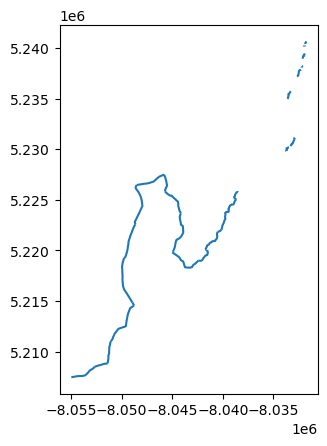

In [35]:
test.plot()

In [55]:
# test[test.NHDPlusID==10000900057062]

,FCode,FType,FlowDir,GNIS_ID,GNIS_Name,LengthKM,NHDPlusID,VPUID,WBArea_Permanent_Identifier,geometry
58040,55800,558,1,00619277,East Branch Swift River,2.635,1.000090e+13,0108,141007825,MULTILINESTRING Z ((-8048645.972 5222563.797 0...


In [36]:
area = gpd.read_file(filepath, layer='NHDWaterbody')

In [37]:
area = area.to_crs(epsg=3857)

<Axes: >

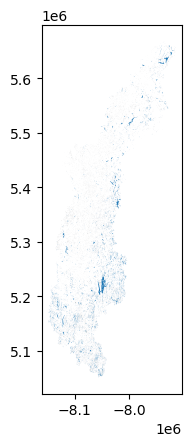

In [38]:
area.plot()

In [16]:
# flowt = flow.iloc[0:100, :]

In [ ]:
# test = flow.clip(area)

(-8060000.0, -8020000.0)

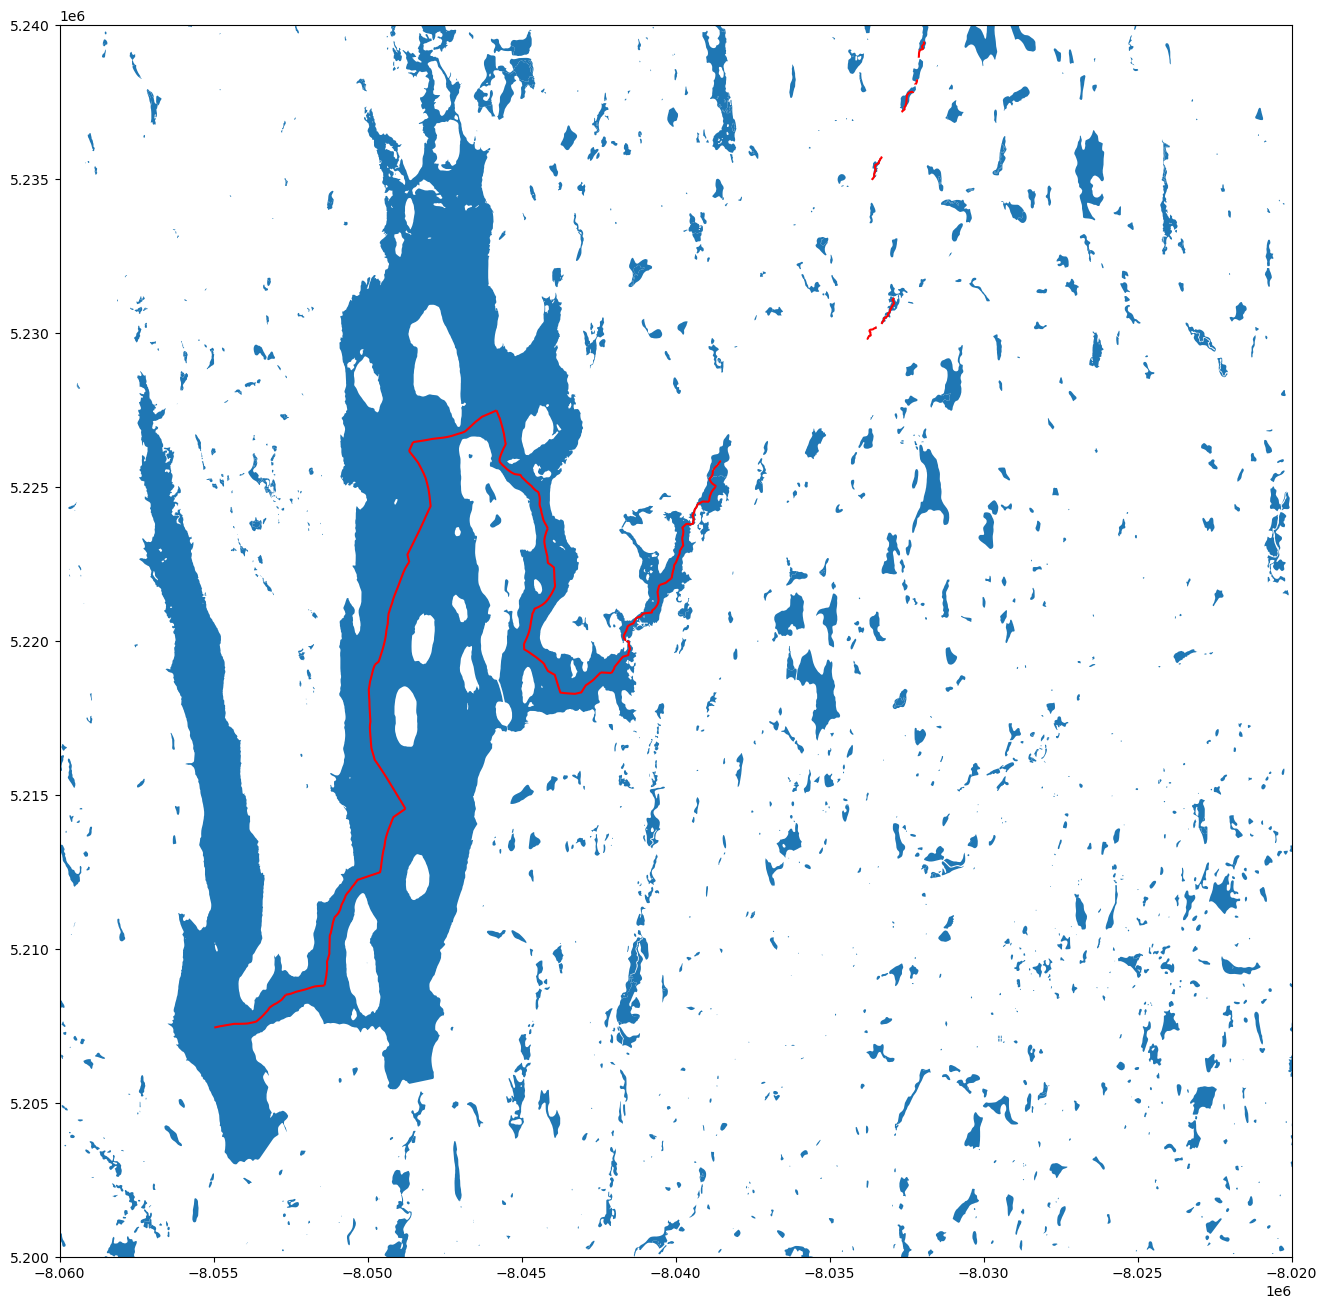

In [50]:
fig, ax = plt.subplots(figsize=(16,16))
test.plot(ax=ax, color='r')
area.plot(ax=ax)
plt.ylim(5200000,5240000)
plt.xlim(-8060000,-8020000)

In [55]:
area_union = area.geometry.union_all()

In [58]:
test1 = test[~test.within(area_union)]

(-8060000.0, -8020000.0)

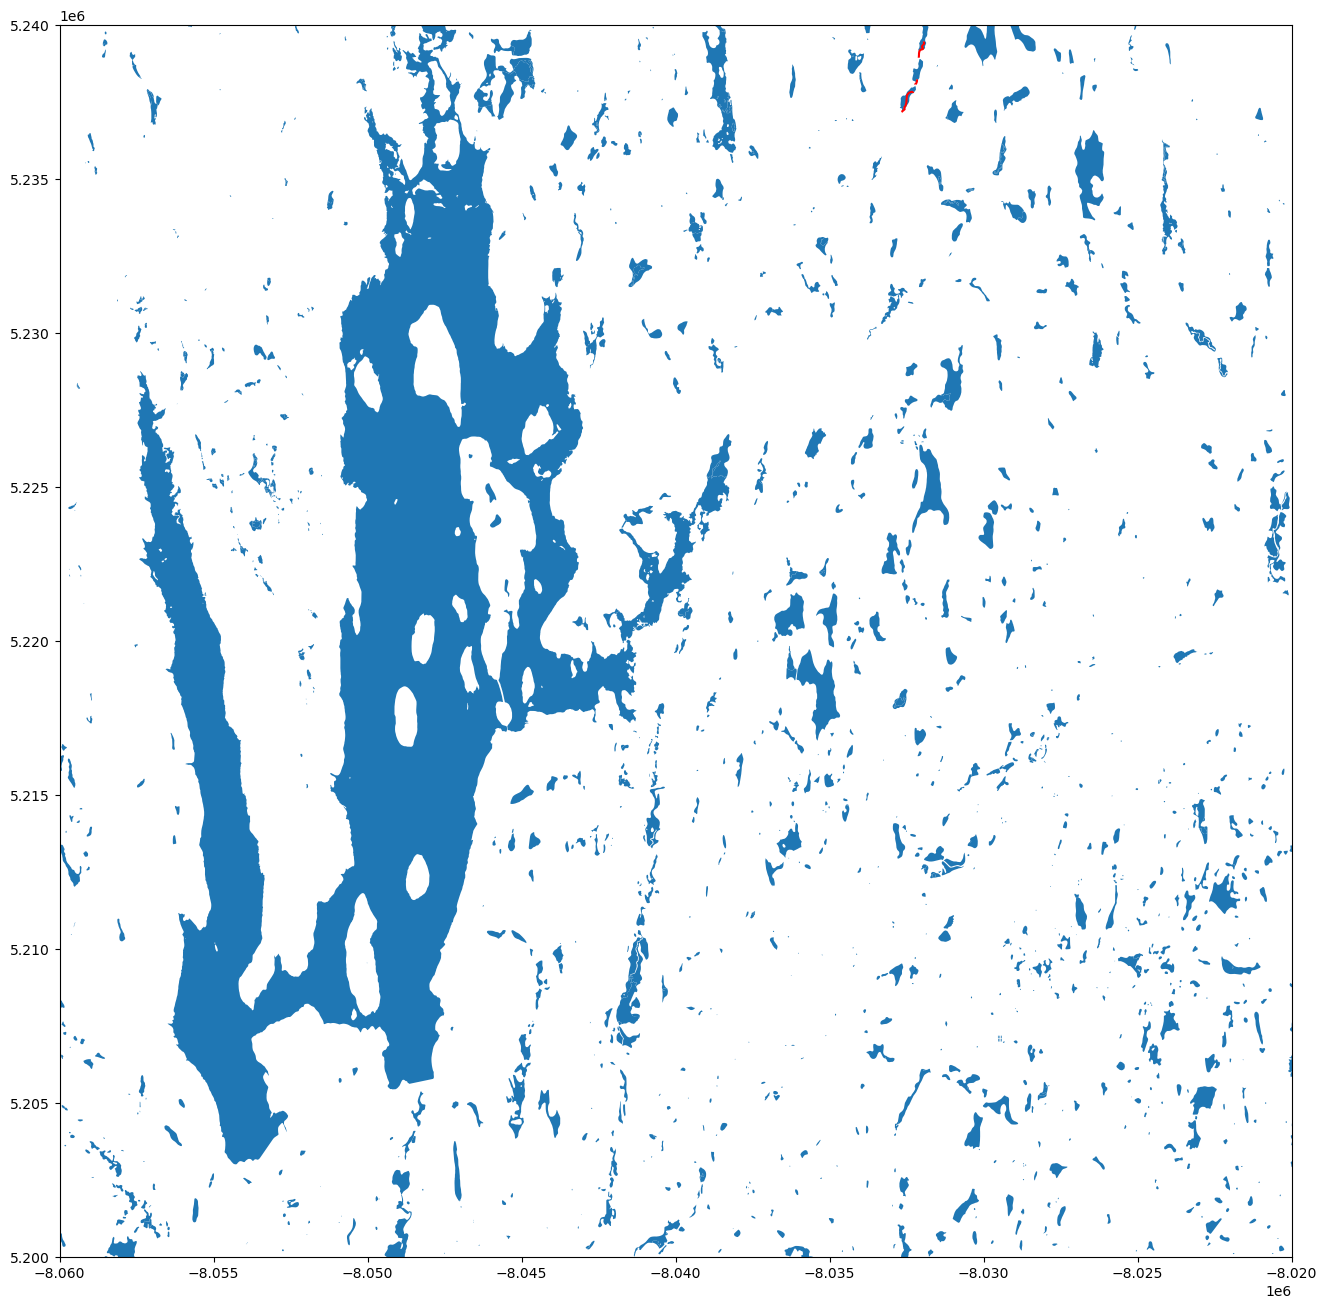

In [60]:
fig, ax = plt.subplots(figsize=(16,16))
test1.plot(ax=ax, color='r')
area.plot(ax=ax)
plt.ylim(5200000,5240000)
plt.xlim(-8060000,-8020000)

In [44]:
import matplotlib.pyplot as plt

In [ ]:
test2 = flow[~flow.geometry.within(area_union)]

<Axes: >

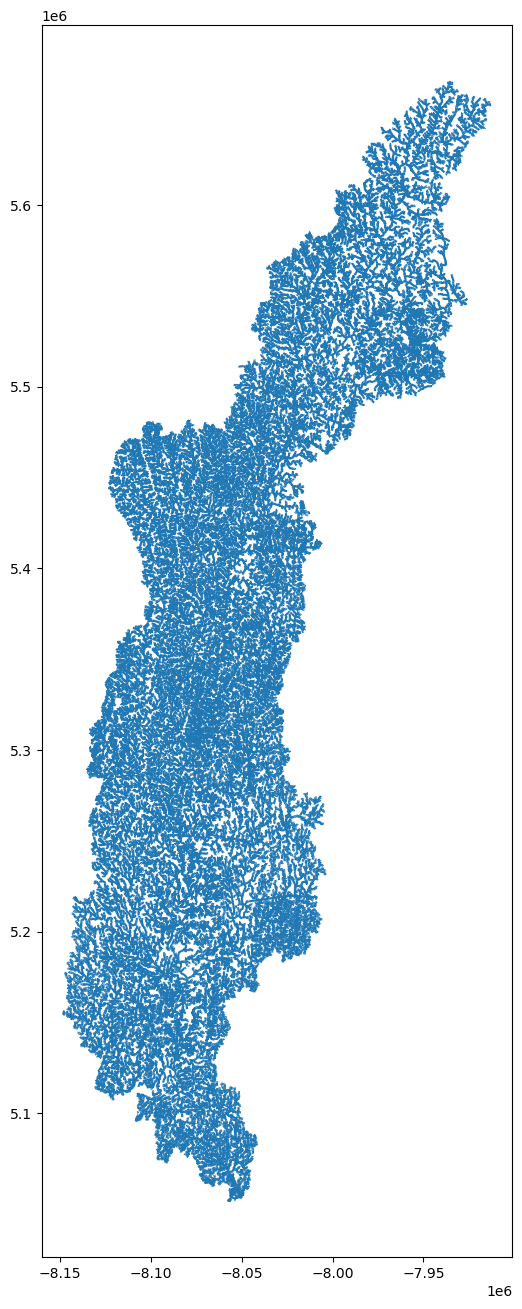

In [48]:
fig, ax = plt.subplots(figsize=(16,16))
test.plot(ax=ax)
# plt.ylim(5300000,5350000)
# plt.xlim(-8100000,-8080000)